# Path and shape regimes of rising bubbles

## Starting point

Our goal is to predict the path and shape regime of rising bubbles depending on the Eötvös and Galilei number defined as

$$
  Ga = \frac{\sqrt{gR}R}{\nu},\quad \text{and}\quad Eo = \frac{\rho gR^2}{\sigma},
$$

with the variables being $g$ - gravitational constant, $\nu$ - kinematic liquid viscosity, $\rho$ - liquid density, and $R$ - equivalent sphere radius. The Galilei number relates interia, buoyancy, and viscous forces. The Eötvös number relates buoyancy and surface tension forces. The path and shape regimes encountered in the range $Ga\in \left[0, 800\right]$ and $Eo\in \left[0,500\right]$ are:

1. axis-symmetric shape, straight rise
2. asymmetric shape, non-oscillatory rise
3. asymmetric shape, oscillatory rise
4. peripheral breakup
5. central breakup

**Why would we want such a classifier?**

Consider the follwoing scenarios:

* The goal is to design a multiphase reactor. The reactor ought to operate in a homgeneous regime. For a given liquid, you want to have an estimate how large the bubbles sparged into the reactor can be to rise on a non-oscillatory path. Of course, the size could be determined graphically from a plot, but if the process is to be automated (e.g., in a software), a functional relationship between size and regime is required.
* In a real bubble column reactor, bubbles in all kinds of regimes will occur. In a scale-reduced simulation of such a reactor, closure models have to be defined, e.g. the drag coefficient in an Euler-Lagrange solver. The standard approach would be to use simple correlations by *Schiller and Naumann* (particles) or by *Tomiyama* (bubbles). Presumably, the correlations will be used far outside their actual range of validity, but actually there are many more correlations available for smaller sub-regimes. The classifier can be used to build a unified correlation covering a much wider parameter range with higher accuracy by automatically switching between different suitable correlations.

The following data was extracted from figure 1 in [Tripathi et al.](https://www.nature.com/articles/ncomms7268)
> Tripathi, M. K. et al. Dynamics of an initially spherical bubble rising in quiescent liquid. Nat. Commun. 6:6268 doi: 10.1038/ncomms7268 (2015)

In general, it would be sensible to gather data form as many sources as possible. The data could also be contradictory, e.g., close to decision boundaries. Most classification algorithms are robust enough to handle such data by drawing decision boundaries accroding to the *majority*.

In [1]:
import pandas as pd

data_path = "../data/path_shape_regimes/"
regimes = ["I", "II", "III", "IV", "V"]
raw_data_files = ["regime_{}.csv".format(regime) for regime in regimes]
files = [pd.read_csv(data_path + file, header=0, names=["Ga", "Eo"]) for file in raw_data_files]
for file, regime in zip(files, regimes):
    file["regime"] = regime
data = pd.concat(files, ignore_index=True)
print("Read {} data points".format(data.shape[0]))
data.sample(5)

Read 103 data points


,Ga,Eo,regime
23,40.153,0.19856,II
73,511.320,3.81350,IV
50,9.839,199.38000,III
57,32.202,19.69400,III
55,22.606,40.55700,III


In [2]:
data.describe()

,Ga,Eo
count,103.000000,103.000000
mean,122.638672,37.759512
std,149.717655,58.145646
min,6.939000,0.099640
25%,22.600500,1.000500
50%,60.116000,10.046000
75%,186.545000,48.188500
max,518.290000,212.910000


 ## Data visualization
 
 To obtain clear stability regions as in figure 1 of the article referenced above, it is advantageous to use the **logarithm** of the features $Ga$ and $Eo$.

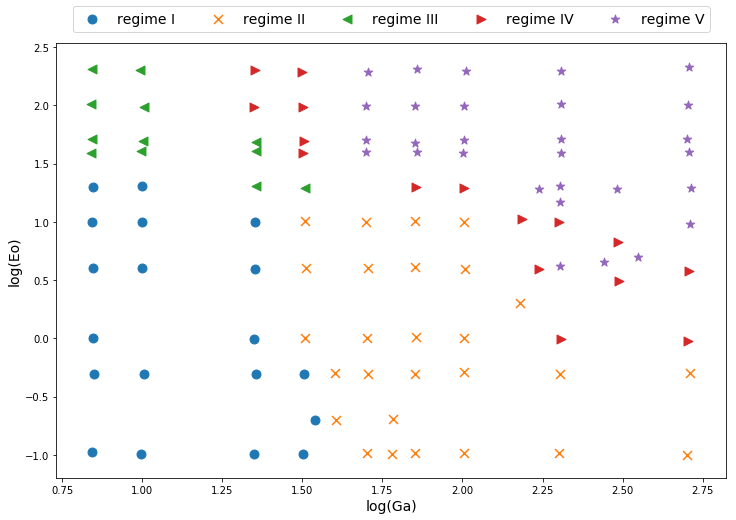

In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
fontsize = 14

logData = data[["Ga", "Eo"]].apply(np.log10)
logData["regime"] = data["regime"].copy()

markers = ["o", "x", "<", ">", "*"]
plt.figure(figsize=(12, 8))
for regime, marker in zip(regimes, markers):
    plt.scatter(logData[logData["regime"] == regime].Ga, logData[logData["regime"] == regime].Eo,
                marker=marker, s=80, label="regime {}".format(regime))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5, fontsize=fontsize)
plt.xlabel(r"log(Ga)", fontsize=fontsize)
plt.ylabel(r"log(Eo)", fontsize=fontsize)
plt.show()

## Manuel binary classification - creating a functional relationship

First, we try to write a classifier by hand. To simplify things, we focus only on regime I and II. From the plot above, the data points of region I and II look almost linearly separable. Therefore, we will define a linear function $z(Ga^\prime, Eo^\prime) = w_1Ga^\prime + w_2Eo^\prime + b$ with the transformed features $Ga^\prime = log(Ga)$ and $Eo^\prime = log(Eo)$ and build a classifier that distingishes the cases

$$
\hat{y}(z (Ga^\prime, Eo^\prime)) = \left\{\begin{array}{lr}
    0, & \text{if } \varphi \leq 0\\
    1, & \text{if } \varphi \gt 0
    \end{array}\right.
$$

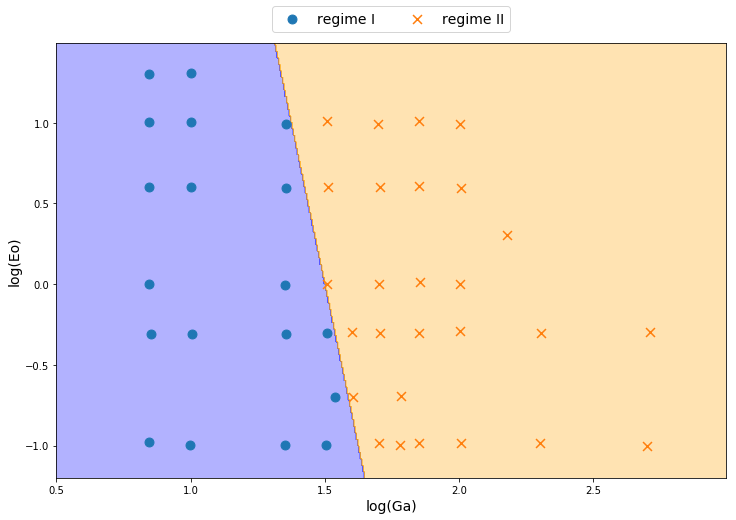

In [4]:
from matplotlib.colors import ListedColormap

# resolution for plotting region contours
resolution = 0.005

def z_func(logGa, logEo):
    w1 = 8.0; w2 = 1; b = -12
    return w1 * logGa + w2 * logEo + b


def y_hat(logGa, logEo):
    return np.heaviside(z_func(logGa, logEo), 0.0)
    
    
plt.figure(figsize=(12, 8))
# color predicted region I and II
xx, yy = np.meshgrid(np.arange(0.5, 3.0, resolution), np.arange(-1.2, 1.5, resolution))
prediction = y_hat(xx.ravel(), yy.ravel())
plt.contourf(xx, yy, prediction.reshape(xx.shape), cmap=ListedColormap(['blue', 'orange']), alpha=0.3)


# plot data point for region I and II
for regime, marker in zip(regimes[:2], markers[:2]):
    plt.scatter(logData[logData["regime"] == regime].Ga, logData[logData["regime"] == regime].Eo,
                marker=marker, s=80, label="regime {}".format(regime))


plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5, fontsize=fontsize)
plt.xlabel(r"log(Ga)", fontsize=fontsize)
plt.ylabel(r"log(Eo)", fontsize=fontsize)
plt.show()

The classifier predicts points of region I and II in the data set correctly. But there is some space for improvement:
* we had to figure out the functional relationship for $\hat{y}$ manually
* the decision boundary does not look always ideal; since we have no knowledge of the true decision boundary but some data points, it would be resonable to search for a boundary which maximizes the distance to the points closest to the boundary
* if we include more regimes, it will become more and more challanging if not impossible to separate the different regions
* the approach only works well for linearly separable data

## Using gradient descent to find the parameters/weights

In the previous section, we manually searched for the slope and offset of a linear function to separate the two classes. This process can be automated by defining and solving an optimization problem. One option would be to define a loss function which expresses the prediction quality. The true label $C$ is known for all points $i$ in the data set. The value of $y$ is $0$ for region I and $1$ for region II. The predicted label $\hat{y}$ depends on $\phi$ and therefore on the weights $w = \left[w_1, w_2, b\right]$. A common loss is the squared difference of true and predicted label $(y-\hat{y})^2$ for all $N$ data points:

$$
  L(w) = \frac{1}{2}\sum\limits_{i=1}^N \left(y_i - \hat{y}_i(w) \right)^2
$$

The prefactor $1/2$ is only for convenience, as will become clear later on. The knobs we can turn to minimize the loss are the weights $w$. The most common algorithm to find suitable weights in machine learning is gradient descent. The idea is to compute the gradient of the loss function w.r.t. the weights and then to change the weights in small steps in negative gradient direction. The gradient of $L$ is

$$
  \frac{\partial L}{\partial w_j} =
  \begin{pmatrix}\frac{\partial L}{\partial w_1}\\
                 \frac{\partial L}{\partial w_2}\\
                 \frac{\partial L}{\partial b}
  \end{pmatrix}=
  -\frac{1}{2}\sum\limits_{i=1}^N 2\left(y_i - \hat{y}_i(w) \right) \frac{\partial \hat{y}_i(w)}{\partial w_j} =
  -\sum\limits_{i=1}^N \left(y_i - \hat{y}_i \right) \delta 
  \begin{pmatrix}Ga^\prime_i\\
                 Eo^\prime_i\\
                 1
  \end{pmatrix},
$$

with the partial derivate of $\hat{y}_i(w)$ being

$$
  \frac{\partial \hat{y}_i(w)}{\partial y_j} = \delta
  \begin{pmatrix}\frac{\partial}{\partial w_1} \left(w_1Ga^\prime_i + w_2Eo^\prime_i + b\right)\\
                 \frac{\partial}{\partial w_2} \left(w_1Ga^\prime_i + w_2Eo^\prime_i + b\right)\\
                 \frac{\partial}{\partial b} \left(w_1Ga^\prime_i + w_2Eo^\prime_i + b\right)
  \end{pmatrix} = \delta
  \begin{pmatrix}Ga^\prime_i\\
                 Eo^\prime_i\\
                 1
  \end{pmatrix}.
$$

The derivative of the [Heaviside step function](https://en.wikipedia.org/wiki/Heaviside_step_function), used in the classifier, is the [Dirac distribution](https://en.wikipedia.org/wiki/Dirac_delta_function), which simply evaluates to one in each point $i$ in the equations above. To update the weights, we change the weights in negative gradient direction by a small fraction of the gradient. The learning rate $\eta$ determines how small or large the weight updates will be. The formula to update the weights is

$$
  w^{n+1} = w^n - \frac{\partial L(w)}{\partial w} =
  \begin{pmatrix}w_1^n\\
                 w_2^n\\
                 b^n
  \end{pmatrix} +
  \sum\limits_{i=1}^N \left(y_i - \hat{y}_i(w^n) \right)
  \begin{pmatrix}Ga^\prime_i\\
                 Eo^\prime_i\\
                 1
  \end{pmatrix}
$$

In [5]:
class SimpleClassifier():
    def __init__(self, eta=0.01, epochs=1000):
        self.eta_ = eta
        self.epochs_ = epochs
        self.weights_ = np.random.rand(3)
        self.loss_ = []

    def train(self, X, y):
        for e in range(self.epochs_):
            self.weights_ += self.eta_ * self.lossGradient(X, y)
            self.loss_.append(self.loss(X, y))
            if self.loss_[-1] < 1.0E-6:
                print("Training converged after {} epochs.".format(e))
                break
    
    def loss(self, X, y):
        return 0.5 * np.sum(np.square(y - self.predict(X)))
    
    def lossGradient(self, X, y):
        return np.concatenate((X, np.ones((X.shape[0], 1))), axis=1).T.dot(y - self.predict(X))
    
    def predict(self, X):
        return np.heaviside(np.dot(np.concatenate((X, np.ones((X.shape[0], 1))), axis=1), self.weights_), 0.0)

In [96]:
from sklearn import preprocessing

reducedData = logData[(logData.regime == "I") | (logData.regime == "II")]
# The LabelBinarizer converts the labels "I" and "II" to 0 and 1
lb = preprocessing.LabelBinarizer()
lb.fit(reducedData.regime)
y = lb.transform(reducedData.regime).ravel()
X = reducedData[["Ga", "Eo"]].values

classifier = SimpleClassifier()
classifier.train(X, y)
print("Computed weights: w1={:.4f}, w2={:.4f}, b={:.4f}".format(classifier.weights_[0], classifier.weights_[1], classifier.weights_[2]))

Training converged after 45 epochs.
Computed weights: w1=0.4684, w2=0.0331, b=-0.6979


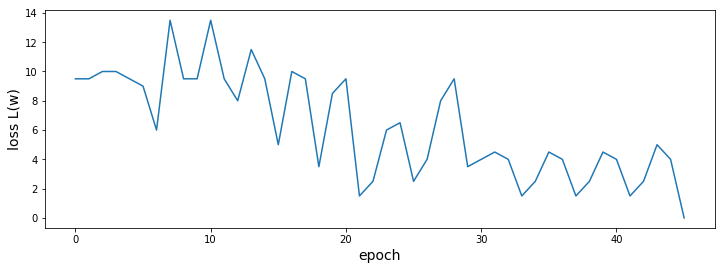

In [97]:
# plot loss over epochs
plt.figure(figsize=(12, 4))
plt.plot(range(len(classifier.loss_)), classifier.loss_)
plt.xlabel(r"epoch", fontsize=fontsize)
plt.ylabel(r"loss L(w)", fontsize=fontsize)
plt.show()

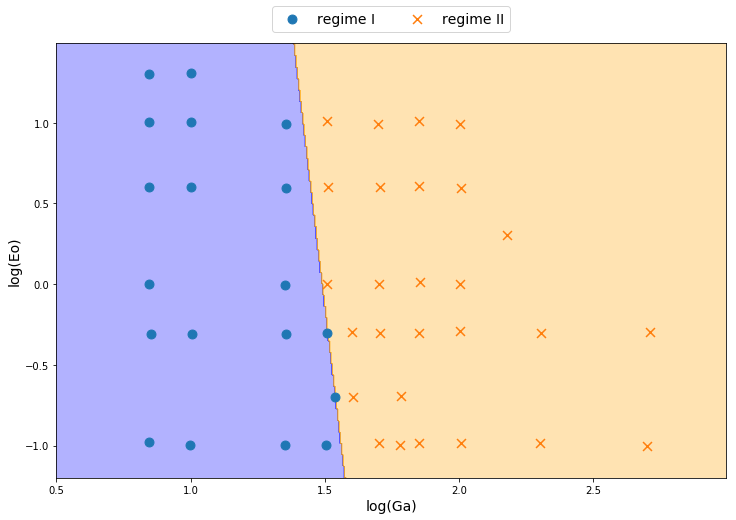

In [98]:
plt.figure(figsize=(12, 8))
prediction = classifier.predict(np.vstack((xx.ravel(), yy.ravel())).T)
plt.contourf(xx, yy, prediction.reshape(xx.shape), cmap=ListedColormap(['blue', 'orange']), alpha=0.3)
for regime, marker in zip(regimes[:2], markers[:2]):
    plt.scatter(reducedData[reducedData["regime"] == regime].Ga, reducedData[reducedData["regime"] == regime].Eo,
                marker=marker, s=80, label="regime {}".format(regime))
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5, fontsize=fontsize)
plt.xlabel(r"log(Ga)", fontsize=fontsize)
plt.ylabel(r"log(Eo)", fontsize=fontsize)
plt.show()

Gradient descent is the standard algorithm in machine learning to determine parameters, e.g., of neural networks. The trained classifier learned to predict all points in the training set correctly. However, the result is still not satisfying in that
* some points are very close to the decision boundary,
* the loss does not decrease monotoneously because the loss function is not continuous (this cloud lead to convergence problems), and
* the algorithm will certainly fail to converge if the data is non linearly separable.

## Using conditional probabilities instead of binary classes

To overcome the convergence issues we need a continuous loss function. The main idea is to consider the odds for a point in the feature space to belong to a certains class instead of making a unique prediction. Before, we used the Heaviside function with $0$ corresponding to region I and $1$ corresponding to region II. Instead we could consider the probability $p$ for a point to be in region II. Probabilities can have values between zero and one. In the special case of binary classification, the probabilities of both classes together add up to one. For example, a point very far in the orange region in the figure above should have a probability close one. In contrast, a point very far in the blue region should have a probability close to zero to be organge. A point very close to the decicion boundary should have a probability around $0.5$. Note that the probability for a point to be in region I is the same as for not being in region II.

Before we used the weighted sum of our features, $z$, to describe how far a point is in region I or II. A negative $z$ led to a point being classified as region I, while a positive $z$ corresponded to region II. Now we have to find a way to convert $z$ into probabilities. There are two requirements which such a transformation function should fulfill:

1. it should map any argument to a positive real number because probabilities are always positive
2. the positive real number should be in the range $0...1$

These requirements are met by the sigmoid function $\sigma (z) = \frac{1}{1+e^{-z}}$.

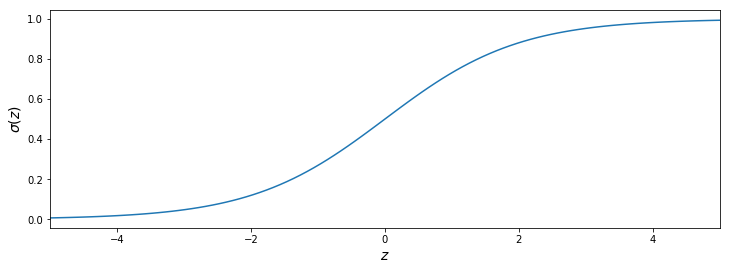

In [99]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

plt.figure(figsize=(12, 4))
plt.plot(np.linspace(-5, 5, 100), sigmoid(np.linspace(-5, 5, 100)))
plt.xlim([-5, 5])
plt.xlabel(r"$z$", fontsize=fontsize)
plt.ylabel(r"$\sigma (z)$", fontsize=fontsize)
plt.show()

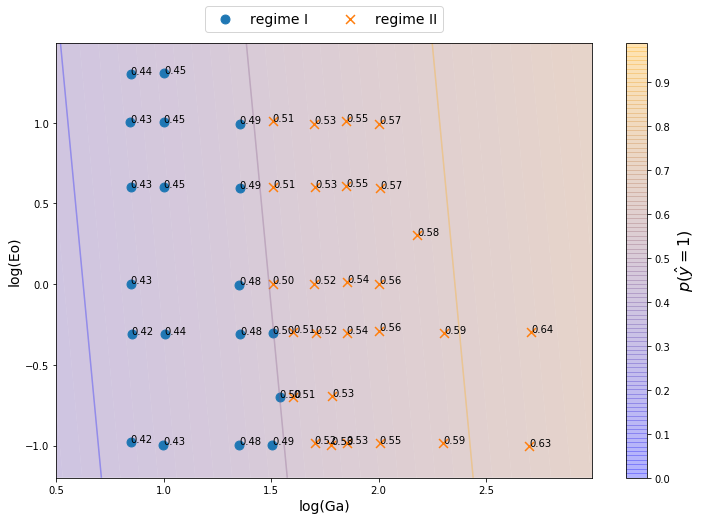

In [100]:
from matplotlib.colors import LinearSegmentedColormap

def probability(X, w):
    z = np.dot(np.concatenate((X, np.ones((X.shape[0], 1))), axis=1), w)
    return 1.0 / (1.0 + np.exp(-z))

plt.figure(figsize=(12, 8))
colors = [(0, 0, 1), (1.0, 0.6470588235294118, 0.0)]
cm = LinearSegmentedColormap.from_list("blue_to_orange", colors, 100)
prediction = probability(np.vstack((xx.ravel(), yy.ravel())).T, classifier.weights_)
plt.contour(xx, yy, prediction.reshape(xx.shape),levels=[np.arange(0, 1.01, 0.1)], cmap=cm, alpha=0.3, antialiased=True)
plt.contourf(xx, yy, prediction.reshape(xx.shape),levels=np.arange(0, 1.0, 0.01), cmap=cm, alpha=0.3, antialiased=True)
plt.colorbar().set_label(r"$p(\hat{y}=1)$", fontsize=16)

for regime, marker in zip(regimes[:2], markers[:2]):
    Xr = reducedData[reducedData["regime"] == regime][["Ga", "Eo"]].values
    point_prob = probability(Xr, classifier.weights_)
    for i, p in enumerate(Xr):
        plt.annotate("{:.2f}".format(point_prob[i]), (p[0], p[1]))
    plt.scatter(reducedData[reducedData["regime"] == regime].Ga, reducedData[reducedData["regime"] == regime].Eo,
                marker=marker, s=80, label="regime {}".format(regime))
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5, fontsize=fontsize)
plt.xlabel(r"log(Ga)", fontsize=fontsize)
plt.ylabel(r"log(Eo)", fontsize=fontsize)
plt.show()

## Maximum likelihood and cross entropy

So far we have got one probability for each point in the training set. The question is now how to combine these probabilities such that we obtain an algorithm to compute the weights. One intuitive approach is trying to maximize the likelihood for all points to be classified correctly. This mean for points in region I we want to maximize $p(\hat{y}=0)$, and for points in region II we maximize $p(\hat{y}=1)$. Assuming that each data point is an independent event, the combined probability of all $N$ points is their product. However, multiplying thounds or millions of values between zero and one would certainly lead to numerical difficulties. Therefore, it is more useful to take the logarithm of the combined probabilities because

1. the product becomes a summation since $\mathrm{ln}(ab) = \mathrm{ln}(a) + \mathrm{ln}(b)$, and
2. it helps to turn the maximization into a minimization problem.

So how is the maximization turned into a minimization? Probabilities take values between zero and one. If the argument of the logarithm is close to one, the result will be close to zero. If the argument is close to zero, the logarithm will be a large negative number. Combining these aspects results in a special loss function called *binary cross entropy*:

$$
  L(w) = -\frac{1}{N}\sum\limits_{i=1}^N y_i \mathrm{ln}(\hat{y}_i) + (1-y_i) \mathrm{ln}(1-\hat{y}_i)
  \quad \text{with} \quad \hat{y}_i = \sigma (z(w)).
$$

Since the logarithm of a value betweem zero and one is negative, the loss is defined as the negative logrithmic probabilities. Taking the mean instead of the sum makes the loss somewhat more independent of the amount of data. High probabilities $\hat{y}_i$ will lead a small cross entropy. Therefore, minimizing the cross entropy is the same is maximizing the likelihood of all points to be classified correctly, and we can use this minimization problem as a criteron to adjust the model's weights $w$ using gradient decent.

Since our classifier function $\hat{y}$ is still rather simple, we can compute the loss gradient by hand:

$$
  \frac{\partial L(w)}{\partial w_j} = -\frac{1}{N}\sum\limits_{i=1}^N
  \frac{y_i}{\hat{y}_i} \frac{\partial \hat{y}_i}{\partial w_j}
  + \frac{1-y_i}{1-\hat{y}_i} \left( -\frac{\partial \hat{y}_i}{\partial w_j} \right)
$$

with the partial derivative of the classifier w.r.t. weigths being

$$
  \frac{\partial\hat{y}_i}{\partial w_j} = \frac{\partial \sigma}{\partial z_i} \frac{\partial z_i}{\partial w_j} =
  \sigma (z_i) (1-\sigma (z_i))
  \begin{pmatrix}Ga^\prime_i\\
                 Eo^\prime_i\\
                 1
  \end{pmatrix} = 
  \hat{y}_i (1-\hat{y}_i)
  \begin{pmatrix}Ga^\prime_i\\
                 Eo^\prime_i\\
                 1
  \end{pmatrix}.
$$

Combining the above equations results in

$$
  \frac{\partial L}{\partial w_j} = -\frac{1}{N}\sum\limits_{i=1}^N (y_i - \hat{y}_i)
  \begin{pmatrix}Ga^\prime_i\\
                 Eo^\prime_i\\
                 1
  \end{pmatrix}.
$$

Some hints if you want to understand the computation in all details:

$$
  \frac{\mathrm{d}}{\mathrm{d}x}\mathrm{ln}(x) = \frac{1}{x},\quad
  \frac{\mathrm{d}}{\mathrm{d}x}\sigma(x) = \sigma (x)(1-\sigma (x)),\quad
  \frac{\mathrm{d} f(g(x))}{\mathrm{d} x} = \frac{\mathrm{d}f}{\mathrm{d}g}\frac{\mathrm{d}g}{\mathrm{d}x}
$$

Now we are ready to implement our improved classifier.

In [132]:
class LogClassifier():
    def __init__(self, eta=1.0, epochs=10000):
        self.eta_ = eta
        self.epochs_ = epochs
        self.weights_ = np.random.rand(3)
        self.loss_ = []

    def train(self, X, y):
        for e in range(self.epochs_):
            self.weights_ += self.eta_ * self.lossGradient(X, y)
            self.loss_.append(self.loss(X, y))
            if self.loss_[-1] < 0.1:
                print("Training converged after {} epochs.".format(e))
                break
    
    def loss(self, X, y):
        logProb = y * np.log(self.probability(X)) + (1.0 - y) * np.log(1.0 - self.probability(X))
        return - np.mean(logProb)
    
    def lossGradient(self, X, y):
        return np.concatenate((X, np.ones((X.shape[0], 1))), axis=1).T.dot(y - self.probability(X)) / X.shape[0]
    
    def probability(self, X):
        z = np.dot(np.concatenate((X, np.ones((X.shape[0], 1))), axis=1), self.weights_)
        return 1.0 / (1.0 + np.exp(-z))
    
    def predict(self, X):
        return np.heaviside(self.probability(X) - 0.5, 0.0)

In [133]:
classifier = LogClassifier()
classifier.train(X, y)
print("Computed weights: w1={:.4f}, w2={:.4f}, b={:.4f}".format(classifier.weights_[0], classifier.weights_[1], classifier.weights_[2]))

Training converged after 3025 epochs.
Computed weights: w1=14.3550, w2=1.3521, b=-21.3915


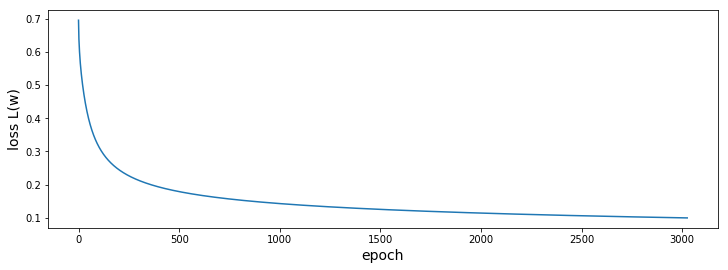

In [134]:
# plot loss over epochs
plt.figure(figsize=(12, 4))
plt.plot(range(len(classifier.loss_)), classifier.loss_)
plt.xlabel(r"epoch", fontsize=fontsize)
plt.ylabel(r"loss L(w)", fontsize=fontsize)
plt.show()

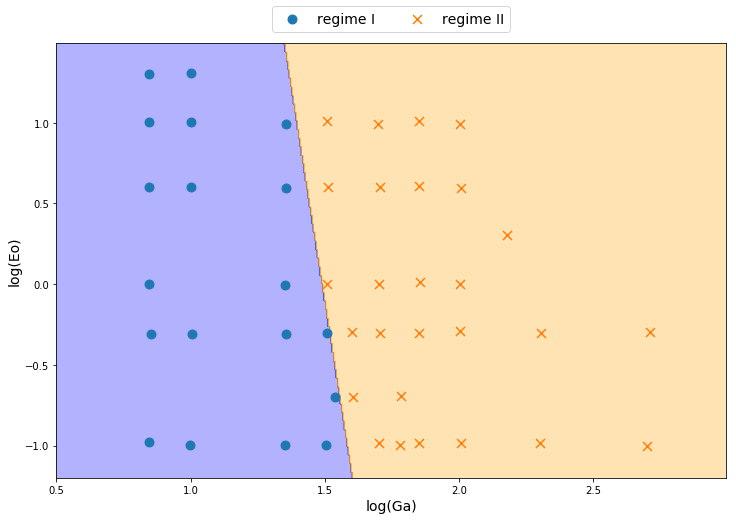

In [135]:
plt.figure(figsize=(12, 8))
prediction = classifier.predict(np.vstack((xx.ravel(), yy.ravel())).T)
plt.contourf(xx, yy, prediction.reshape(xx.shape), cmap=ListedColormap(['blue', 'orange']), alpha=0.3)
for regime, marker in zip(regimes[:2], markers[:2]):
    plt.scatter(reducedData[reducedData["regime"] == regime].Ga, reducedData[reducedData["regime"] == regime].Eo,
                marker=marker, s=80, label="regime {}".format(regime))
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5, fontsize=fontsize)
plt.xlabel(r"log(Ga)", fontsize=fontsize)
plt.ylabel(r"log(Eo)", fontsize=fontsize)
plt.show()

Observations

- many iterations since gradient becomes smaller so closer we get to the minimum
- loss decreases monotoneously
- decision boundary looks slightly better

## Non-linear decicion boundaries

## The multi-layer percepton

In [11]:
%load_ext tikzmagic

The tikzmagic extension is already loaded. To reload it, use:
  %reload_ext tikzmagic


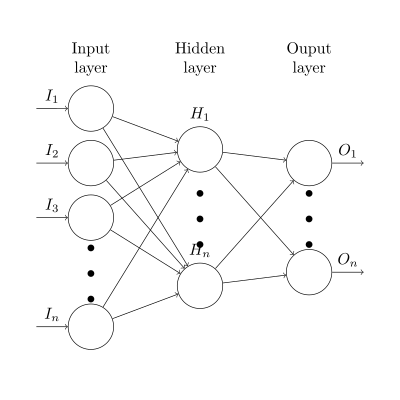

In [22]:
%%tikz -s 400,400 -sc 1.2 -f svg
\input{combined_linear_models.tikz}

## Multi-class classification

- one-hot encoding
- generalized cross-entropy